In [1]:
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from tqdm import tqdm
import argparse
import glob
import xml.etree.ElementTree as ET 
import cv2
import ast
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


import warnings
warnings.filterwarnings("ignore")

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
path_an = "../pcb/PCB_DATASET/Annotations"
print(path_an)

../pcb/PCB_DATASET/Annotations


In [4]:
dataset = {
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
            "class":[],    
            "file":[],
            "width":[],
            "height":[],
           }
all_files = []
for path, subdirs, files in os.walk(path_an):
#     print([path, subdirs, files])
    for name in files:
        all_files.append(os.path.join(path, name))

# print(all_files)       
print(type(dataset))
print(dataset)

<class 'dict'>
{'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'file': [], 'width': [], 'height': []}


In [5]:
for anno in all_files:
    # print(anno)
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        # print(elem)
        
        if 'size' in elem.tag:
            # print('[size] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            # print('[object] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                
                # print('attr = %s\n' % attr)
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['class']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]       

In [6]:
data=pd.DataFrame(dataset)
data

xmin  ymin  xmax  ymax            class                   file  width  \
0     1346   677  1479   789     missing_hole     10_missing_hole_01   2240   
1     1907   490  1982   571     missing_hole     10_missing_hole_01   2240   
2     1963   651  2053   727     missing_hole     10_missing_hole_01   2240   
3     1794  1144  1891  1234     missing_hole     10_missing_hole_01   2240   
4     1017  1270  1111  1350     missing_hole     10_missing_hole_01   2240   
...    ...   ...   ...   ...              ...                    ...    ...   
2948   640   604   719   670  spurious_copper  11_spurious_copper_03   2282   
2949   414  1311   463  1424  spurious_copper  11_spurious_copper_03   2282   
2950  1424  1160  1488  1234  spurious_copper  11_spurious_copper_03   2282   
2951  1463  1565  1520  1655  spurious_copper  11_spurious_copper_03   2282   
2952  1739  1613  1820  1670  spurious_copper  11_spurious_copper_03   2282   

      height  
0       2016  
1       2016  
2       2016  
3       2016  
4       2016  
...      ...  
2948    2248  
2949    2248  
2950    2248  
2951    2248  
2952    2248  

[2953 rows x 8 columns]

In [7]:
train,test = train_test_split(data, shuffle=True, test_size=0.2, random_state=34)

In [8]:
train.shape, test.shape

((2362, 8), (591, 8))

In [9]:
train.head()

xmin  ymin  xmax  ymax         class                file  width  height
1838  1162  1201  1228  1264  open_circuit  04_open_circuit_12   3056    2464
2149  1018  1276  1054  1378          spur          06_spur_08   2868    2316
1784  2713   946  2746   979  open_circuit  01_open_circuit_05   3034    1586
1042   939  1288   975  1363    mouse_bite    06_mouse_bite_04   2868    2316
1992   831  2110   971  2157          spur          04_spur_19   3056    2464

In [10]:
test.head()

xmin  ymin  xmax  ymax         class                file  width  height
90    1443   854  1494   902  missing_hole  06_missing_hole_01   2868    2316
1315  2010   435  2084   482    mouse_bite    04_mouse_bite_03   3056    2464
1244  1927   629  1987   688    mouse_bite    07_mouse_bite_01   2904    1921
1572  1625   541  1664   586  open_circuit  09_open_circuit_10   2775    2159
1515  1261   815  1317   862  open_circuit  07_open_circuit_08   2904    1921

In [11]:
classes_la = {"missing_hole": 0, "mouse_bite": 1, "open_circuit":2, "short": 3, 'spur': 4,'spurious_copper':5}

train["class"] = train["class"].apply(lambda x: classes_la[x])
test["class"] = test["class"].apply(lambda x: classes_la[x])

In [12]:
train.head()

xmin  ymin  xmax  ymax  class                file  width  height
1838  1162  1201  1228  1264      2  04_open_circuit_12   3056    2464
2149  1018  1276  1054  1378      4          06_spur_08   2868    2316
1784  2713   946  2746   979      2  01_open_circuit_05   3034    1586
1042   939  1288   975  1363      1    06_mouse_bite_04   2868    2316
1992   831  2110   971  2157      4          04_spur_19   3056    2464

In [13]:
test.head()

xmin  ymin  xmax  ymax  class                file  width  height
90    1443   854  1494   902      0  06_missing_hole_01   2868    2316
1315  2010   435  2084   482      1    04_mouse_bite_03   3056    2464
1244  1927   629  1987   688      1    07_mouse_bite_01   2904    1921
1572  1625   541  1664   586      2  09_open_circuit_10   2775    2159
1515  1261   815  1317   862      2  07_open_circuit_08   2904    1921

In [14]:
df = train.copy()
df_grp = df.groupby(['file'])
print(df_grp)

In [15]:
df_grp.size()

file
01_missing_hole_01       2
01_missing_hole_02       2
01_missing_hole_03       3
01_missing_hole_04       2
01_missing_hole_05       4
                        ..
12_spurious_copper_06    4
12_spurious_copper_07    3
12_spurious_copper_08    5
12_spurious_copper_09    3
12_spurious_copper_10    5
Length: 690, dtype: int64

In [16]:
image_name = '01_missing_hole_02'
image_group = df_grp.get_group(image_name)
print(image_group)

    xmin  ymin  xmax  ymax  class                file  width  height
96  2366   803  2406   860      0  01_missing_hole_02   3034    1586
97  1506   802  1559   856      0  01_missing_hole_02   3034    1586


In [17]:
bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
print([bbox, type(bbox)])

[    xmin  ymin  xmax  ymax
96  2366   803  2406   860
97  1506   802  1559   856, <class 'pandas.core.frame.DataFrame'>]


In [18]:
def plot_image(image_name):
    print(image_name)
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    path ="../pcb/PCB_DATASET/images/"
    if "missing" in name.split('_'):
        path += 'Missing_hole/'
    if "mouse" in name.split('_'):
        path += 'Mouse_bite/'
    if "open" in name.split('_'):
        path += 'Open_circuit/'
    if "short" in name.split('_'):
        path += 'Short/'
    if "spur" in name.split('_'):
        path += 'Spur/'
    if "spurious" in name.split('_'):
        path += 'Spurious_copper/'
   
    img = immg.imread(path+""+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(box)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        # ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()


01_missing_hole_01
[1613  334 1679  396]
[1726  794 1797  854]


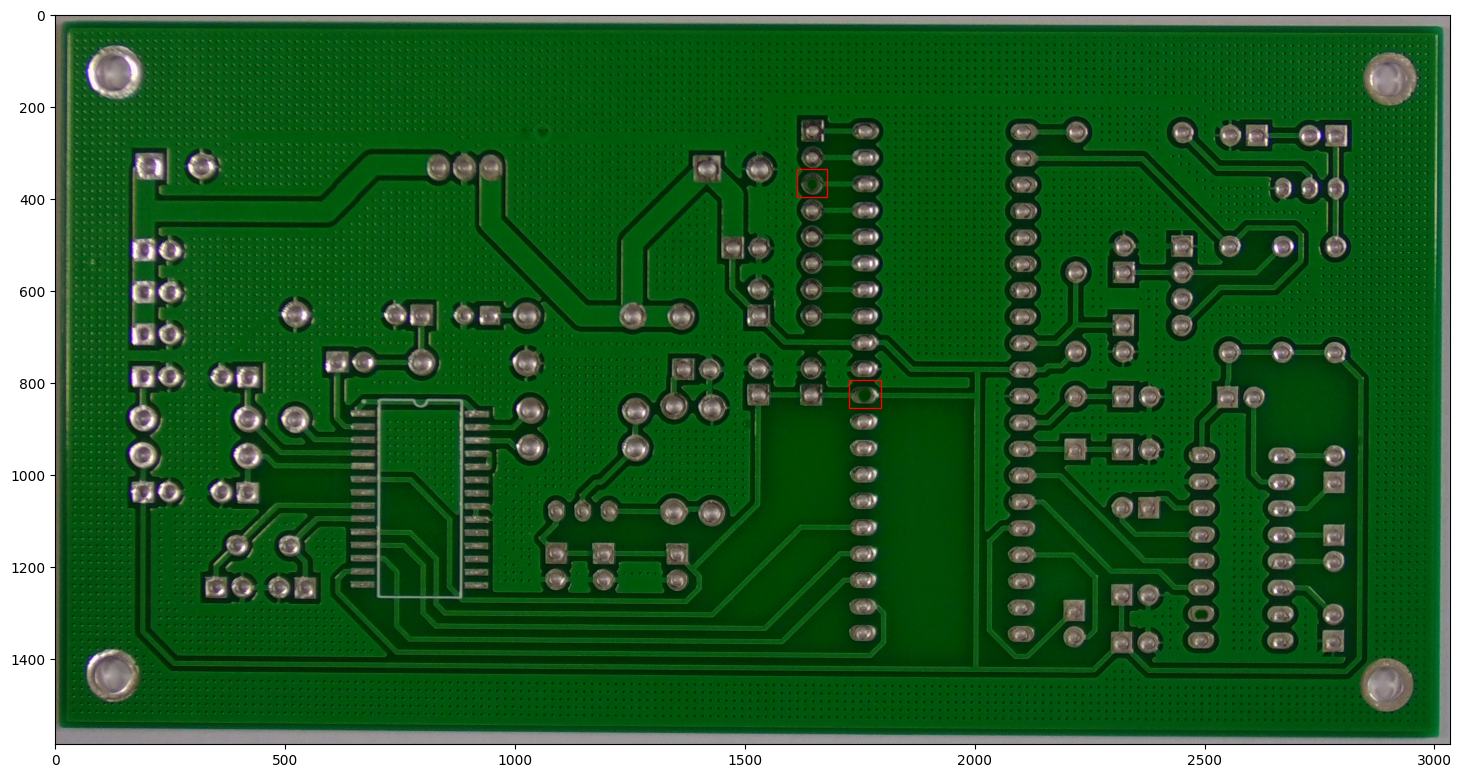

In [19]:
name = '01_missing_hole_01'
plot_image(name)

06_short_06
[1206 1264 1269 1324]
[1510  920 1572  975]
[1740  800 1801  853]


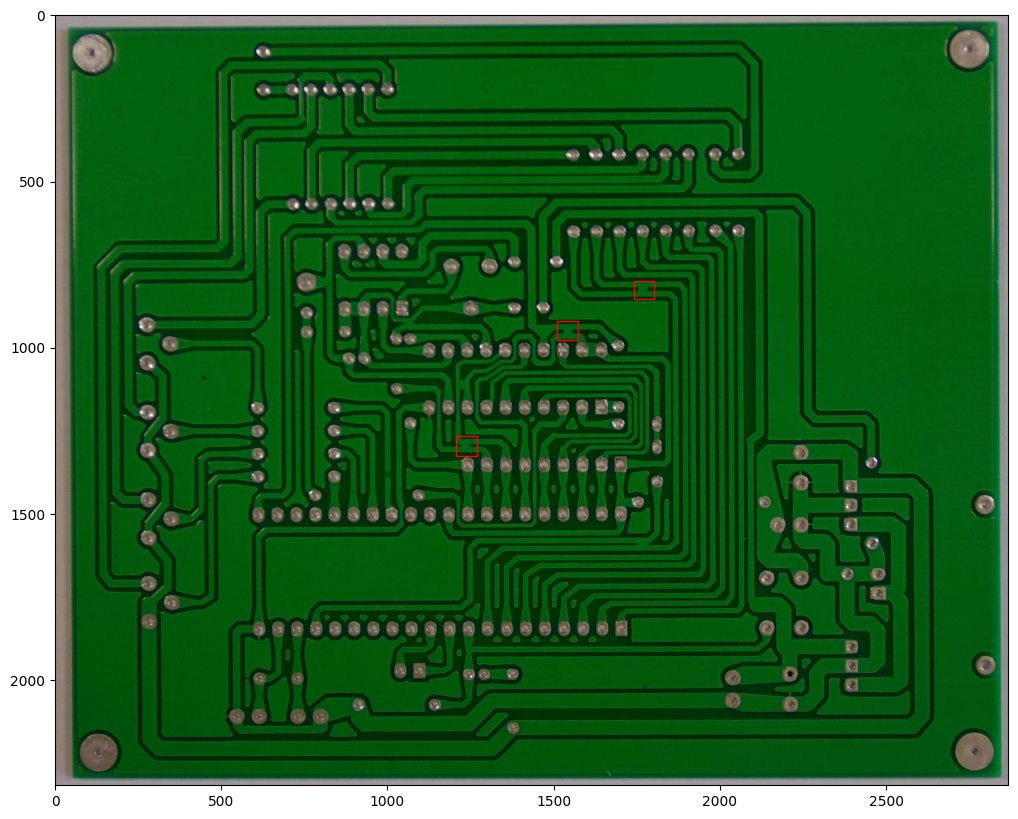

In [20]:
name = train.file[500]
plot_image(name)

10_missing_hole_02
[1419 1113 1491 1174]
[ 945  692 1052  780]
[ 908 1085 1003 1164]
[2014 1351 2085 1431]
[588 783 717 892]


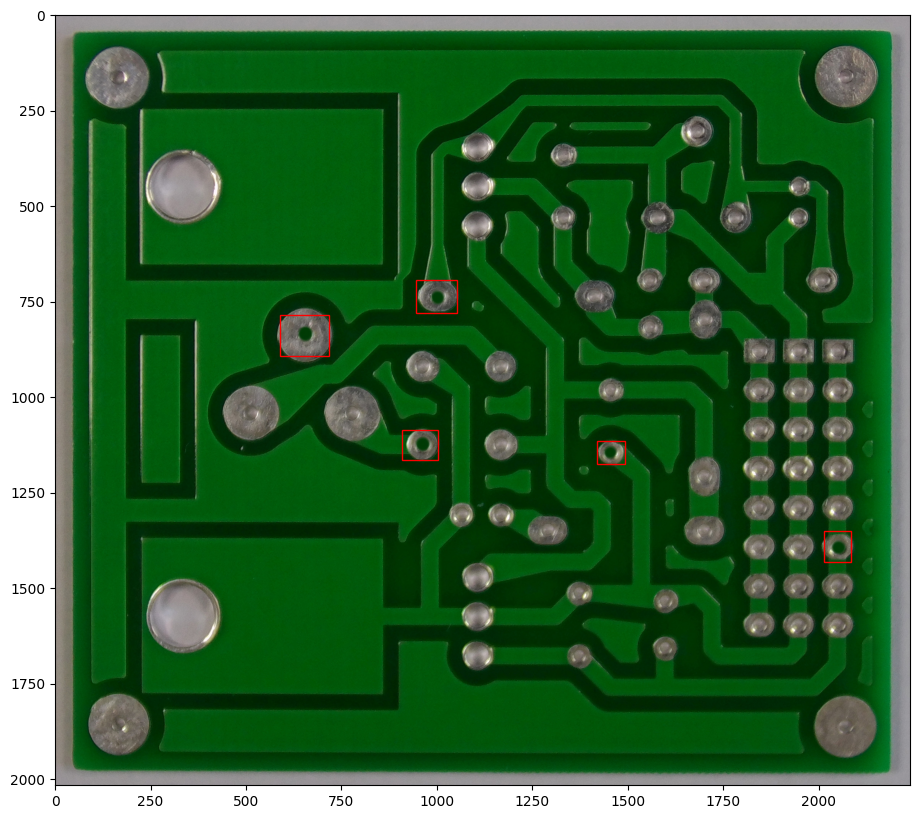

In [21]:
name = train.file[100]
plot_image(name)

In [22]:
class pcbData(object):
    def __init__(self, df, IMG_DIR, transforms): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['file'].unique().tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        a = ''
        if "missing" in image_id.split('_'):
            a = 'Missing_hole/'
        elif "mouse" in image_id.split('_'):
            a = 'Mouse_bite/'
        elif "open" in image_id.split('_'):
            a = 'Open_circuit/'
        elif "short" in image_id.split('_'):
            a = 'Short/'
        elif "spur" in image_id.split('_'):
            a = 'Spur/'
        elif "spurious" in image_id.split('_'):
            a = 'Spurious_copper/'
        image_values = self.df[self.df['file'] == image_id]
        image = cv2.imread(self.img_dir+a+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

In [23]:
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [24]:
path ="../pcb/PCB_DATASET/images/"
pcb_dataset   = pcbData(df, path, get_train_transform())

In [25]:
type(pcb_dataset[0]), len(pcb_dataset[0]), type(pcb_dataset[0][0]), type(pcb_dataset[0][1]), type(pcb_dataset[0][2])

(tuple, 3, torch.Tensor, dict, str)

In [26]:
print([pcb_dataset[0][0], pcb_dataset[0][1], pcb_dataset[0][2]])

[tensor([[[0.6471, 0.6157, 0.6196,  ..., 0.6784, 0.6706, 0.6706],
         [0.6275, 0.6157, 0.6078,  ..., 0.6706, 0.6667, 0.6745],
         [0.6353, 0.6392, 0.6196,  ..., 0.6627, 0.6667, 0.6745],
         ...,
         [0.6353, 0.6353, 0.6353,  ..., 0.6431, 0.6471, 0.6431],
         [0.6392, 0.6353, 0.6314,  ..., 0.6431, 0.6431, 0.6353],
         [0.6510, 0.6431, 0.6353,  ..., 0.6431, 0.6392, 0.6314]],

        [[0.5647, 0.5451, 0.5569,  ..., 0.6157, 0.6078, 0.6078],
         [0.5451, 0.5451, 0.5451,  ..., 0.6078, 0.6039, 0.6118],
         [0.5529, 0.5686, 0.5569,  ..., 0.6000, 0.6039, 0.6118],
         ...,
         [0.5725, 0.5725, 0.5725,  ..., 0.5922, 0.5961, 0.5961],
         [0.5765, 0.5725, 0.5686,  ..., 0.5922, 0.5922, 0.5922],
         [0.5882, 0.5804, 0.5725,  ..., 0.5922, 0.5882, 0.5882]],

        [[0.6235, 0.6000, 0.6078,  ..., 0.6667, 0.6588, 0.6588],
         [0.6039, 0.6000, 0.5961,  ..., 0.6588, 0.6549, 0.6627],
         [0.6118, 0.6235, 0.6078,  ..., 0.6510, 0.6549, 0

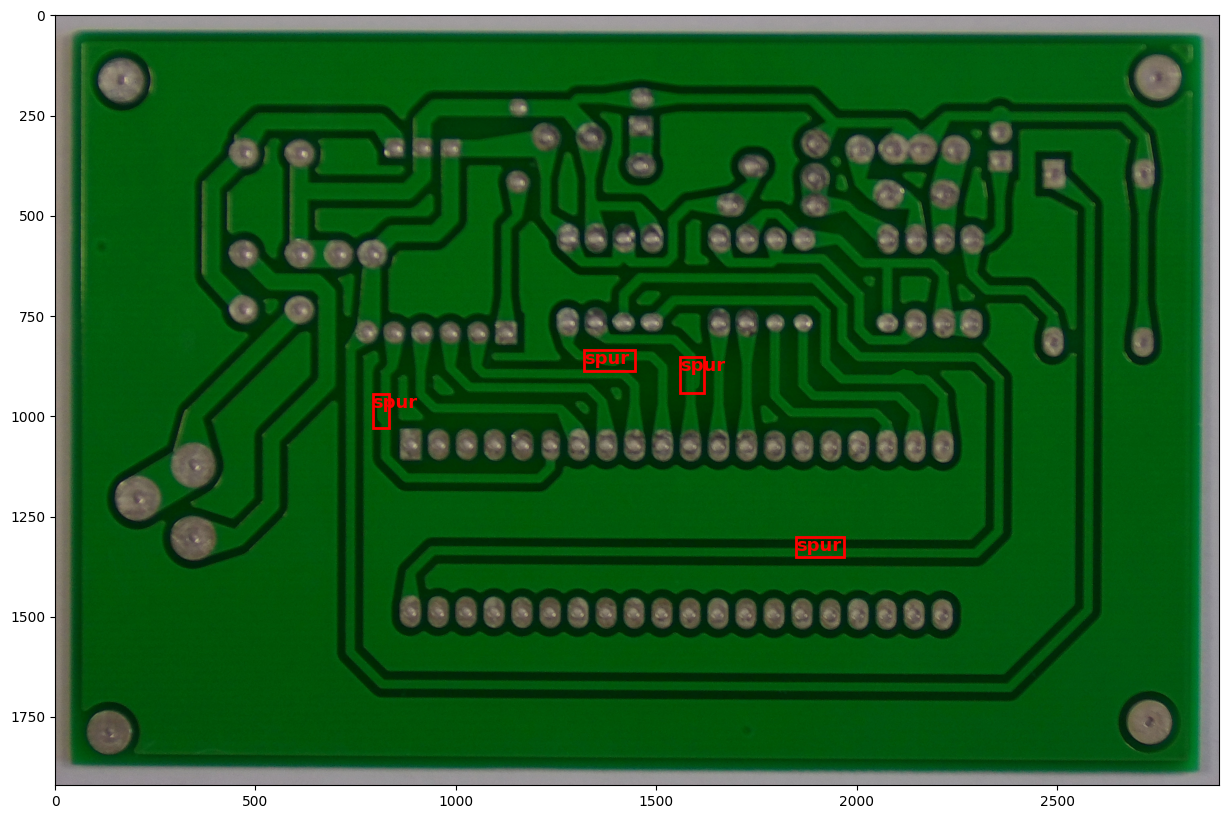

In [27]:
img, tar, _ = pcb_dataset[random.randint(0,50)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for j in tar["labels"].tolist():
    classes_la = {0:"missing_hole", 1: "mouse_bite", 2:"open_circuit",3: "short", 4:'spur',5:'spurious_copper'}
    l = classes_la[j]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()


In [28]:
len(df)

2362

In [29]:
image_ids = df['file'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = df[df['file'].isin(valid_ids)]
train_df = df[df['file'].isin(train_ids)]
train_df.shape,valid_df.shape

((86, 8), (2276, 8))

In [30]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [31]:
train_dataset = pcbData(df, path, get_train_transform())
valid_dataset = pcbData(df, path, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

In [32]:
next(iter(train_data_loader))

((tensor([[[0.6471, 0.6157, 0.6196,  ..., 0.6784, 0.6706, 0.6706],
           [0.6275, 0.6157, 0.6078,  ..., 0.6706, 0.6667, 0.6745],
           [0.6353, 0.6392, 0.6196,  ..., 0.6627, 0.6667, 0.6745],
           ...,
           [0.6353, 0.6353, 0.6353,  ..., 0.6431, 0.6471, 0.6431],
           [0.6392, 0.6353, 0.6314,  ..., 0.6431, 0.6431, 0.6353],
           [0.6510, 0.6431, 0.6353,  ..., 0.6431, 0.6392, 0.6314]],
  
          [[0.5647, 0.5451, 0.5569,  ..., 0.6157, 0.6078, 0.6078],
           [0.5451, 0.5451, 0.5451,  ..., 0.6078, 0.6039, 0.6118],
           [0.5529, 0.5686, 0.5569,  ..., 0.6000, 0.6039, 0.6118],
           ...,
           [0.5725, 0.5725, 0.5725,  ..., 0.5922, 0.5961, 0.5961],
           [0.5765, 0.5725, 0.5686,  ..., 0.5922, 0.5922, 0.5922],
           [0.5882, 0.5804, 0.5725,  ..., 0.5922, 0.5882, 0.5882]],
  
          [[0.6235, 0.6000, 0.6078,  ..., 0.6667, 0.6588, 0.6588],
           [0.6039, 0.6000, 0.5961,  ..., 0.6588, 0.6549, 0.6627],
           [0.6118, 0.

In [33]:
## num_classes = 6 # + background
num_classes = 6

# load a model; pre-trained on COCO
# .. fpn = 'feature pyramid network'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [35]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [36]:
num_epochs = 1

In [37]:
train_data_loader

In [38]:
import sys
best_epoch = 0
min_loss = sys.maxsize

for epoch in range(num_epochs):
    tk = tqdm(train_data_loader)
    model.train();
    for images, targets, image_ids in tk:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    print(f"Epoch #{epoch} loss: {loss_value}") 
        
    #validation 
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to(device) for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()

  0%|          | 0/690 [00:00<?, ?it/s]

Epoch #0 loss: 0.09466620534658432


  0%|          | 0/690 [00:00<?, ?it/s]

In [39]:
img,target,_ = valid_dataset[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  30
real #boxes:  5


In [40]:
torch.save(model.state_dict(), 'pcbdetection.pt')

In [41]:
y_true =[]
y_pred = []
for i in range(50):
    img,target,_ = valid_dataset[i]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        y_true.append(target['labels'][0])
        y_pred.append(prediction['labels'][0])

In [42]:
y_pred

[tensor(2),
 tensor(4),
 tensor(2),
 tensor(1),
 tensor(4),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(5),
 tensor(3),
 tensor(4),
 tensor(5),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(3),
 tensor(5),
 tensor(2),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(5),
 tensor(5),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(5),
 tensor(2),
 tensor(3),
 tensor(5),
 tensor(1),
 tensor(5),
 tensor(2),
 tensor(2),
 tensor(4),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(5),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(3),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(1),
 tensor(3)]

In [43]:
yy_pred = []
for v in y_pred:
    yy_pred.append(v.cpu())

In [44]:
yy_pred

[tensor(2),
 tensor(4),
 tensor(2),
 tensor(1),
 tensor(4),
 tensor(1),
 tensor(1),
 tensor(2),
 tensor(5),
 tensor(3),
 tensor(4),
 tensor(5),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(3),
 tensor(5),
 tensor(2),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(5),
 tensor(5),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(5),
 tensor(2),
 tensor(3),
 tensor(5),
 tensor(1),
 tensor(5),
 tensor(2),
 tensor(2),
 tensor(4),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(5),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(3),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(1),
 tensor(3)]

In [45]:
y_true

[tensor(2),
 tensor(4),
 tensor(2),
 tensor(1),
 tensor(4),
 tensor(4),
 tensor(1),
 tensor(2),
 tensor(5),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(3),
 tensor(5),
 tensor(2),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(5),
 tensor(5),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(5),
 tensor(2),
 tensor(3),
 tensor(5),
 tensor(1),
 tensor(5),
 tensor(2),
 tensor(2),
 tensor(4),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(5),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(3),
 tensor(0),
 tensor(5),
 tensor(5),
 tensor(1),
 tensor(3)]

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, yy_pred)

array([[ 0,  0,  0,  1,  0,  1],
       [ 0,  9,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  1],
       [ 0,  1,  0,  0,  9,  0],
       [ 0,  0,  0,  0,  0, 10]])

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_true, yy_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         9
           3       0.90      0.90      0.90        10
           4       1.00      0.90      0.95        10
           5       0.83      1.00      0.91        10

    accuracy                           0.92        50
   macro avg       0.77      0.80      0.78        50
weighted avg       0.89      0.92      0.90        50

